<a href="https://www.kaggle.com/code/vishalgupta74/customer-churn-96-acc-gradient-boosting?scriptVersionId=163011338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

Text(0.5, 1.0, 'Count of TARGET Variable per category')

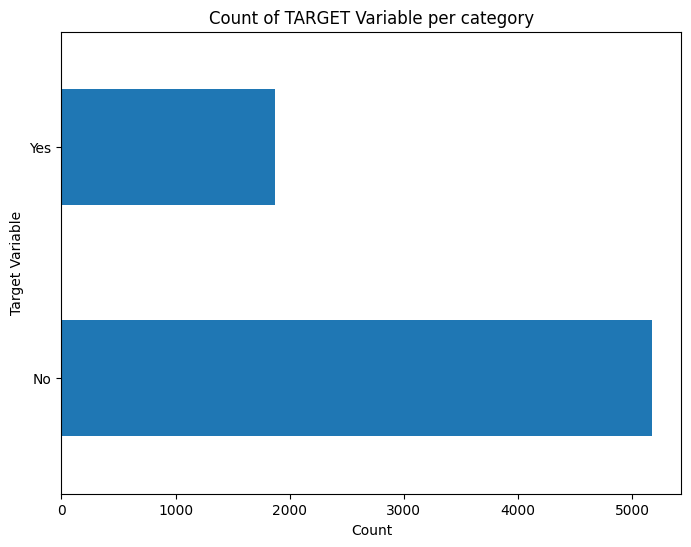

In [9]:
df['Churn'].value_counts().plot(kind = 'barh',figsize = (8,6))
plt.xlabel("Count")
plt.ylabel("Target Variable")
plt.title("Count of TARGET Variable per category")

In [10]:
100*df['Churn'].value_counts()/len(df['Churn'])


Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

In [11]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

**Observation** - imbalanced data

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

errors='coerce' will convert invalid parsing to NaN.

In [13]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [14]:
df[df['TotalCharges'].isnull() == True]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [15]:
df.dropna(inplace=True)

In [16]:
for i in df.columns[1:]:
    if df[i].dtype == 'object':
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes' 'No phone service']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['No' 'Yes' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [17]:
cols = []

In [18]:
for column in df.columns[1:]: 
    if df[column].dtype == 'object':  
        if "No internet service" in df[column].values: 
            cols.append(column)

In [19]:
categorical = df.select_dtypes("object")
categorical.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [20]:
cols

['OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [21]:
for i in cols:
    df[i].replace("No internet service",'No',inplace=True)

/tmp/ipykernel_27/2853469656.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[i].replace("No internet service",'No',inplace=True)


In [22]:
df["MultipleLines"].replace("No phone service","No",inplace=True)

/tmp/ipykernel_27/1060004933.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["MultipleLines"].replace("No phone service","No",inplace=True)


In [23]:
for i in df.columns[1:]:
    if df[i].dtype == 'object':
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['No' 'Yes']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [24]:
df.drop('customerID',axis=1,inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

In [26]:
df.tenure.value_counts()

tenure
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: count, Length: 72, dtype: int64

In [27]:
df.tenure.max()

72

In [28]:

# Group the tenure in bins of 12 months
labels = []
for i in range(1, 72, 12):
    labels.append("{0} - {1}".format(i, i + 11))
    
df['tenure_group'] = pd.cut(df['tenure'], bins=range(1, 80, 12), right=False, labels=labels)

In [29]:
df['tenure_group'].value_counts()

tenure_group
1 - 12     2175
61 - 72    1407
13 - 24    1024
25 - 36     832
49 - 60     832
37 - 48     762
Name: count, dtype: int64

In [30]:
df.drop('tenure',axis=1,inplace=True)

In [31]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1 - 12
3,Male,0,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1 - 12


# Data Exploration

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


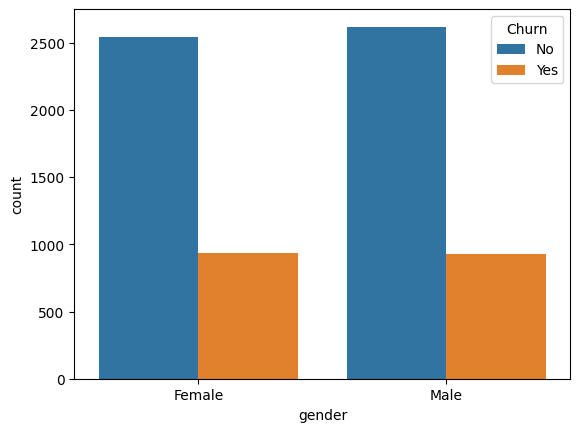

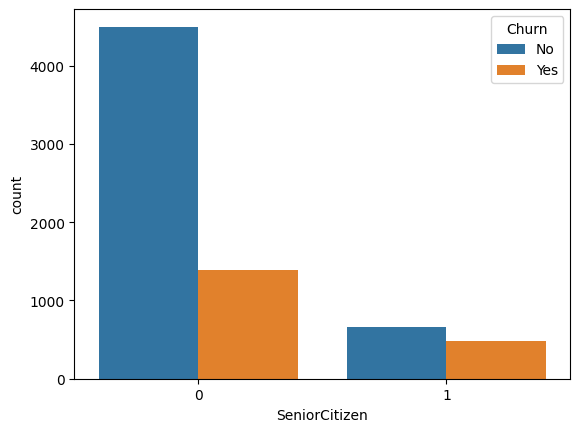

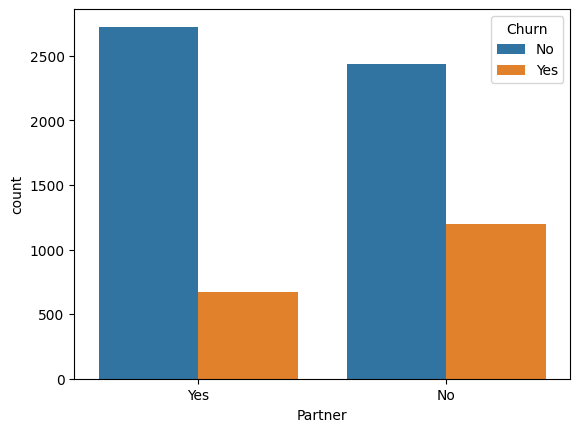

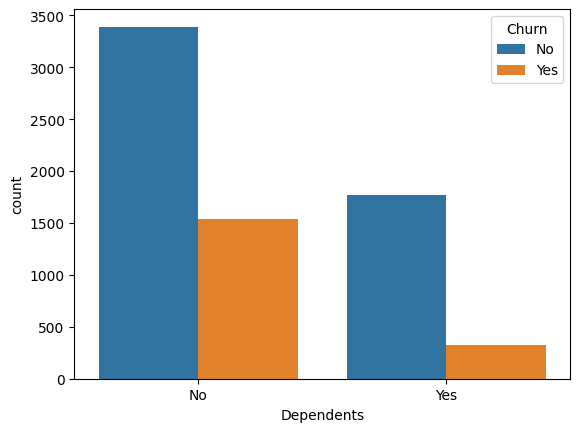

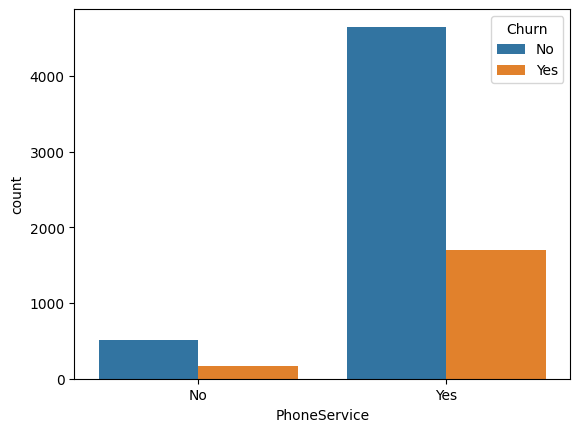

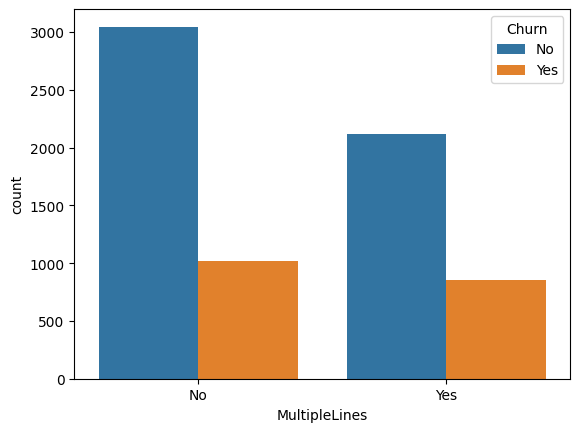

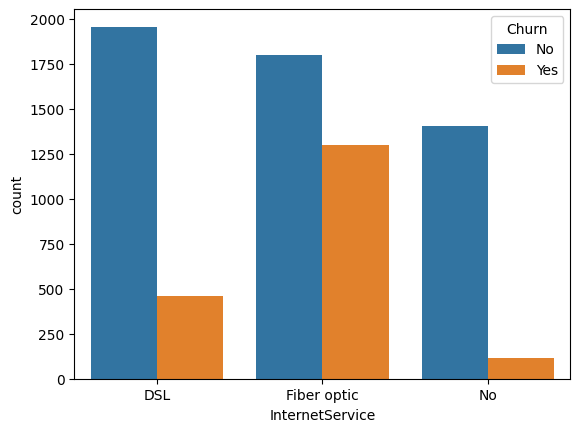

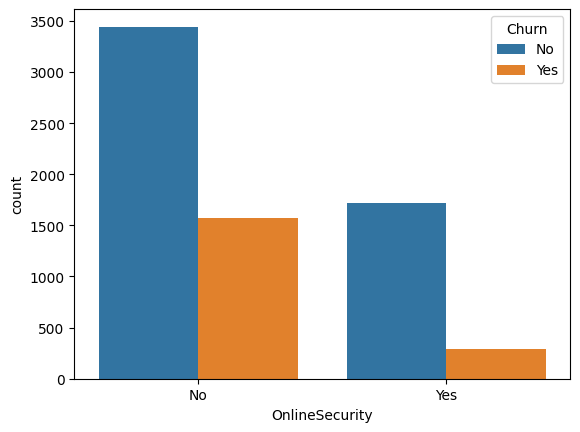

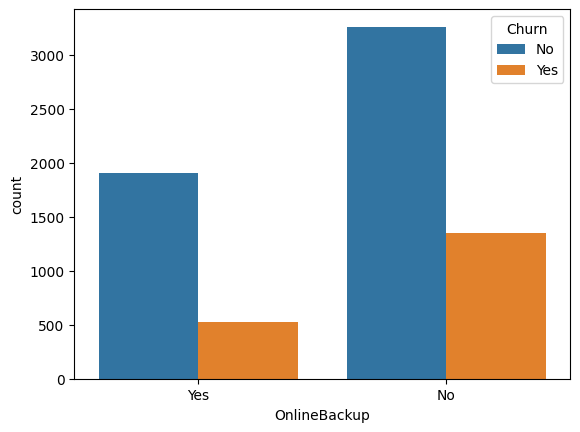

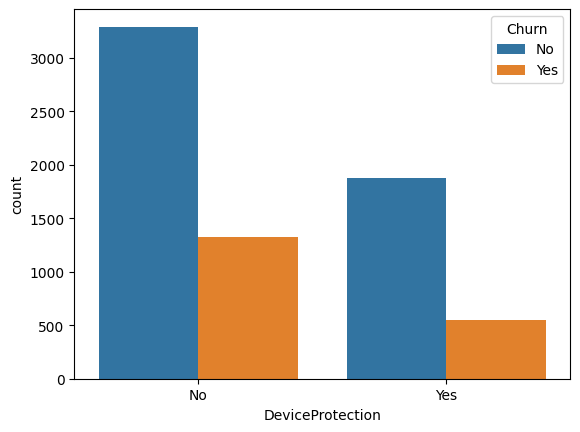

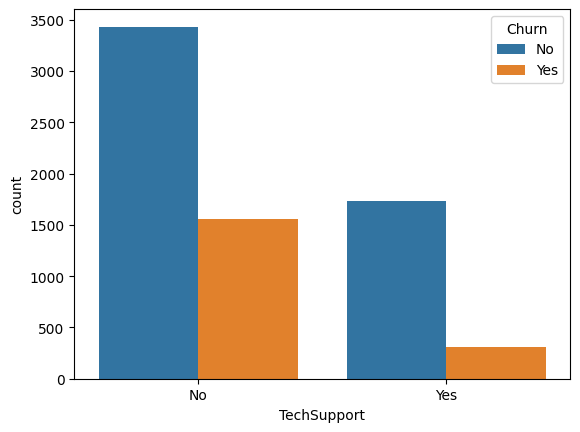

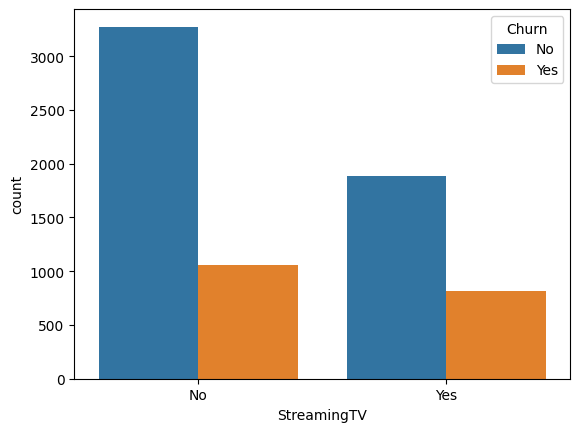

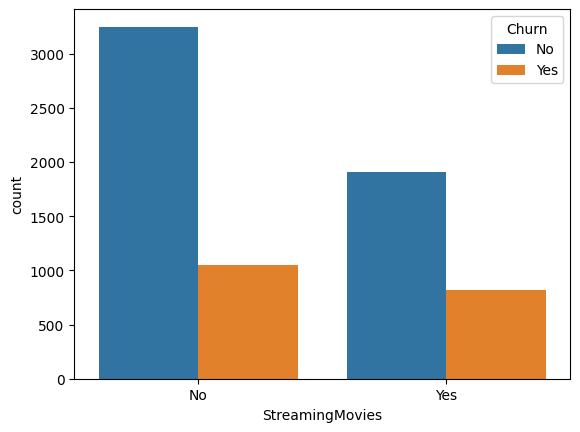

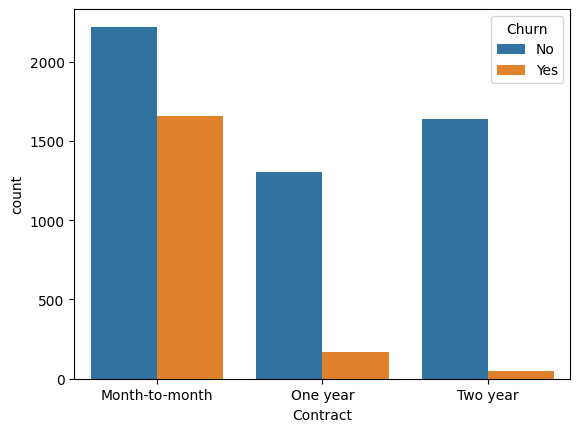

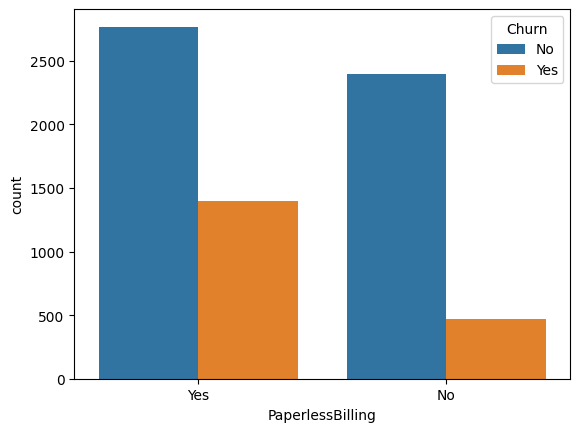

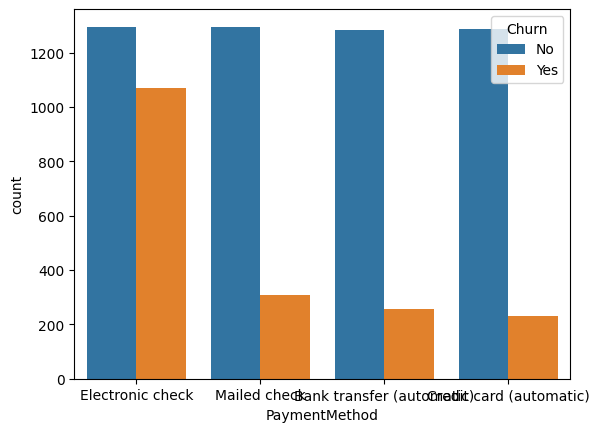

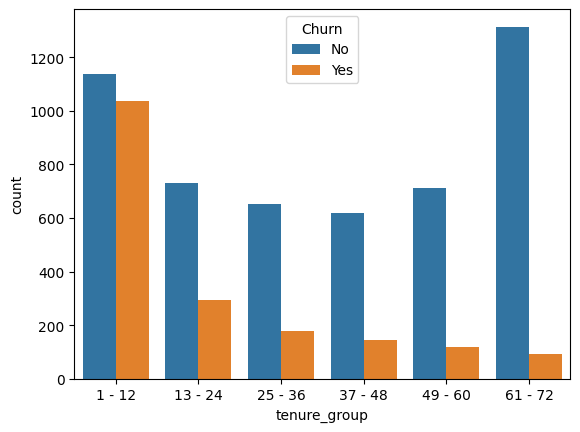

In [32]:
for i, predictor in enumerate(df.drop(columns=['Churn', 'TotalCharges', 'MonthlyCharges'])):
    plt.figure(i)
    sns.countplot(data=df, x=predictor, hue='Churn')

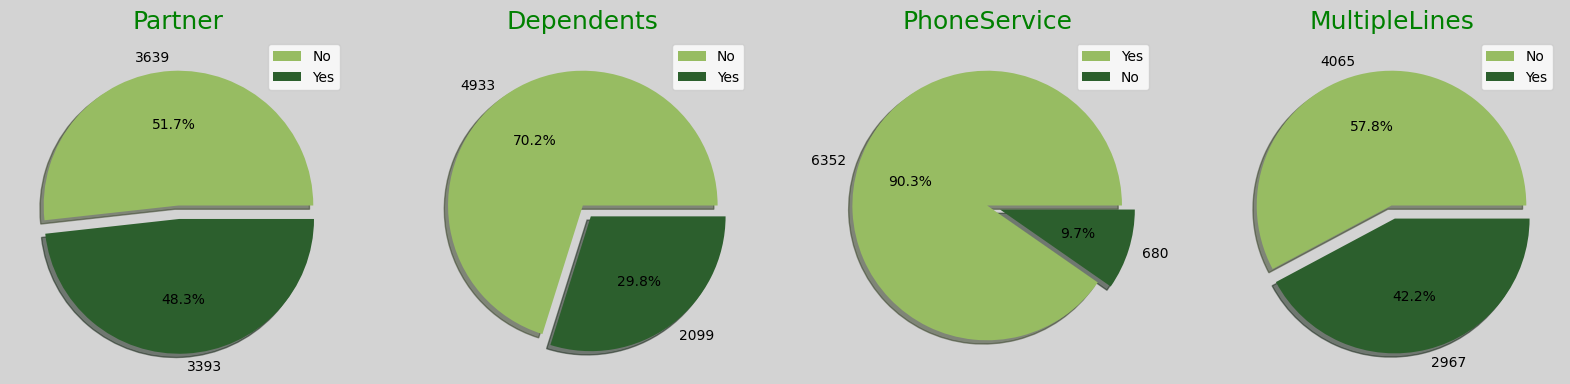

In [33]:
categ_columns = df.select_dtypes("object").columns[1:-1]

fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[:4]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",
           explode=[0,0.1],shadow=True,colors=['#97BC62FF', '#2C5F2D'])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)

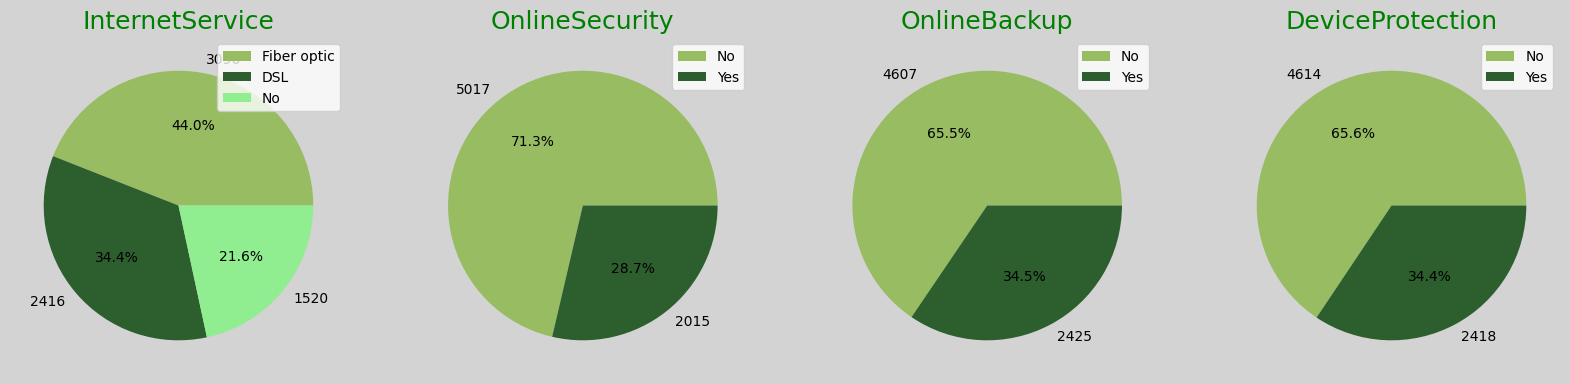

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

colors = [('#97BC62FF', '#2C5F2D',"lightgreen"),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D')]


for i, column in enumerate(categ_columns[4:8]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",
           colors=colors[i])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index,loc="best")

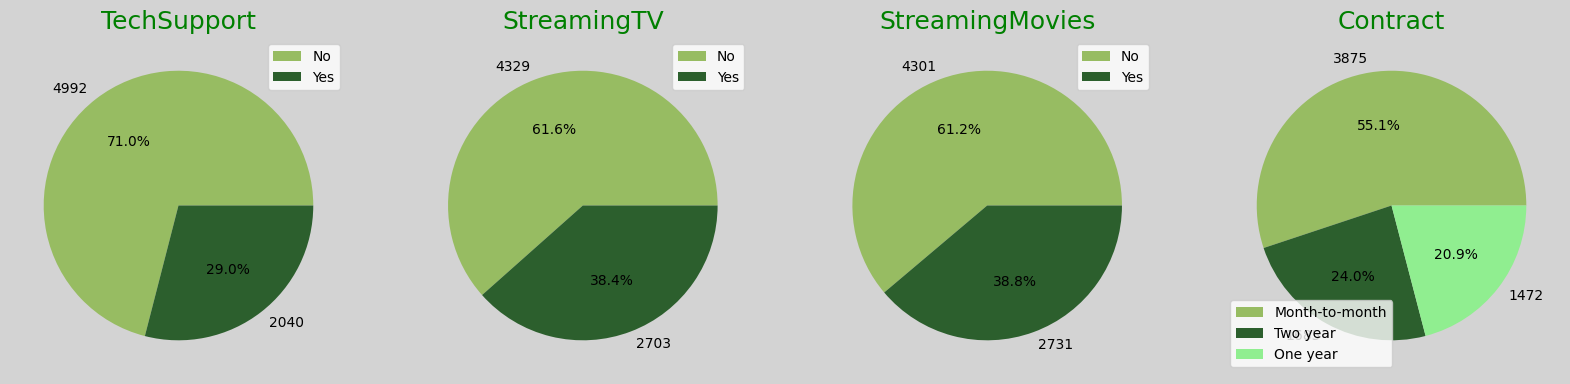

In [35]:
colors = [('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D'),('#97BC62FF', '#2C5F2D',"lightgreen")]
fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[8:12]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",colors=colors[i])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)

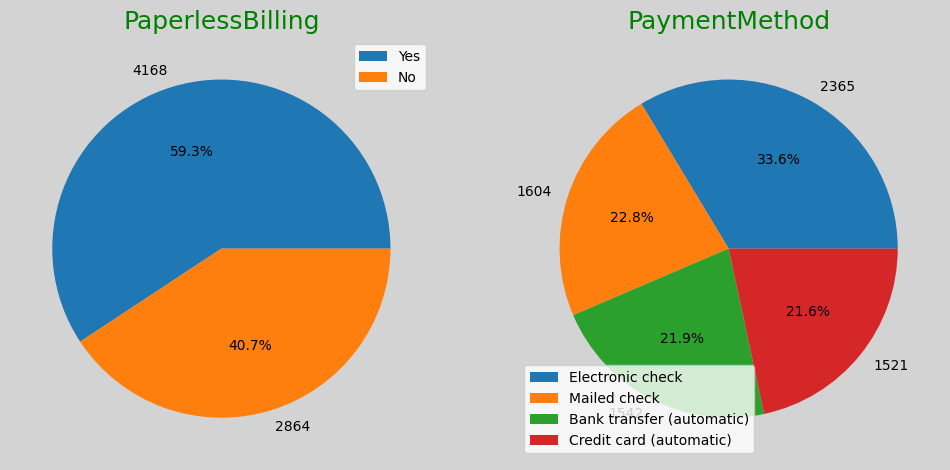

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[12:]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%")
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Distribution of TotalCharges')

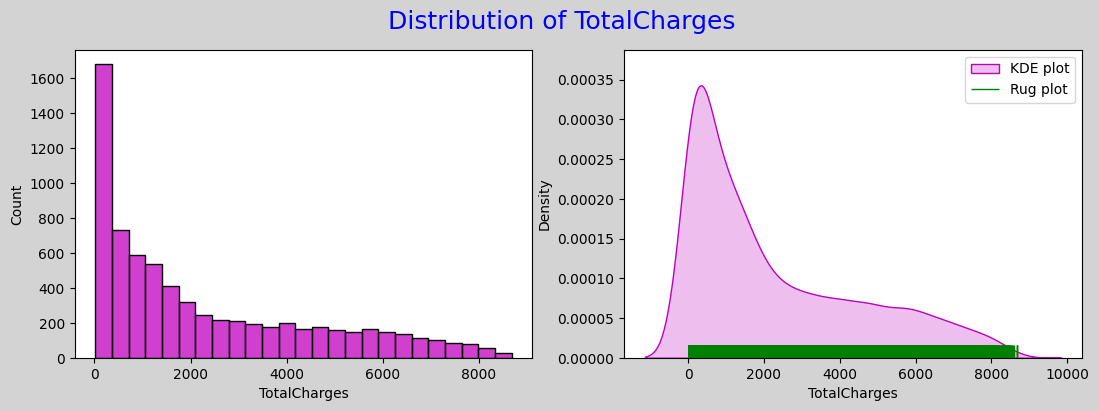

In [37]:
fig , ax = plt.subplots(1,2,figsize=(13,4),facecolor="lightgray")
sns.histplot(df["TotalCharges"],color="m",ax=ax[0])
sns.kdeplot(df["TotalCharges"],fill=True,color="m",ax=ax[1])
sns.rugplot(df["TotalCharges"],height=0.04,color="green",ax=ax[1])
ax[1].legend(["KDE plot","Rug plot"])
fig.suptitle("Distribution of TotalCharges",size=18,color="blue")

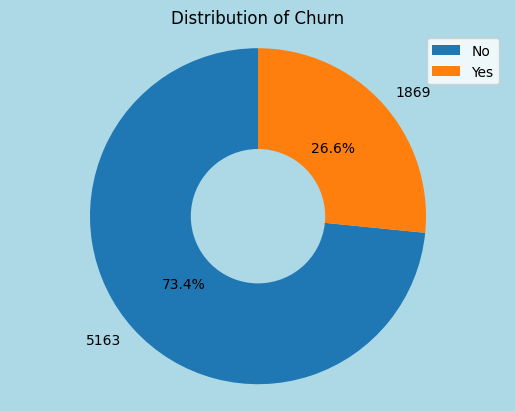

In [38]:
fig, ax = plt.subplots(facecolor="lightblue")
data = df["Churn"].value_counts()
ax.pie(data,autopct='%1.1f%%', startangle=90,labels=data.values)
ax.legend(data.index)
ax.set_title("Distribution of Churn")
centre_circle = plt.Circle((0,0),0.4,fc='lightblue')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal');

In [39]:
pd.crosstab(df["Churn"],df["Dependents"])

Dependents,No,Yes
Churn,,
No,3390,1773
Yes,1543,326


In [40]:
print(df.groupby(by=["Churn","gender"])["Dependents"].value_counts())

Churn  gender  Dependents
No     Female  No            1686
               Yes            858
       Male    No            1704
               Yes            915
Yes    Female  No             774
               Yes            165
       Male    No             769
               Yes            161
Name: count, dtype: int64


In [41]:
categorical = df.select_dtypes("object")
categorical.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [42]:
df['Churn'] = np.where(df.Churn == 'Yes',1,0)

# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# df['Churn'] = label_encoder.fit_transform(df['Churn'])

In [43]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,Female,0,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1 - 12
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25 - 36
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1 - 12
3,Male,0,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,37 - 48
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1 - 12


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7032 non-null   object  
 1   SeniorCitizen     7032 non-null   int64   
 2   Partner           7032 non-null   object  
 3   Dependents        7032 non-null   object  
 4   PhoneService      7032 non-null   object  
 5   MultipleLines     7032 non-null   object  
 6   InternetService   7032 non-null   object  
 7   OnlineSecurity    7032 non-null   object  
 8   OnlineBackup      7032 non-null   object  
 9   DeviceProtection  7032 non-null   object  
 10  TechSupport       7032 non-null   object  
 11  StreamingTV       7032 non-null   object  
 12  StreamingMovies   7032 non-null   object  
 13  Contract          7032 non-null   object  
 14  PaperlessBilling  7032 non-null   object  
 15  PaymentMethod     7032 non-null   object  
 16  MonthlyCharges    7032 non-nu

In [45]:
df_encoded = pd.get_dummies(df)
# Convert boolean values to integers (0/1)
df_encoded = df_encoded.astype(int)
df_encoded.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


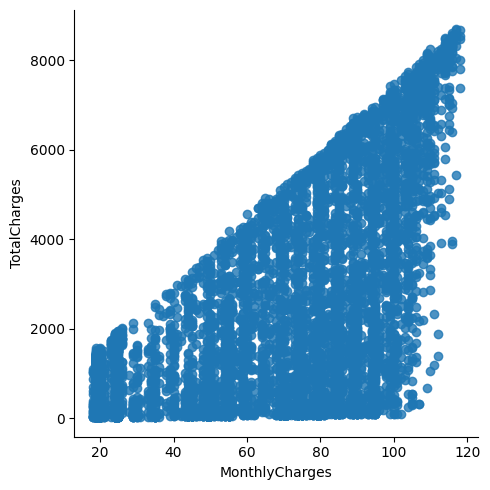

In [46]:
sns.lmplot(data=df_encoded, x='MonthlyCharges', y='TotalCharges', fit_reg=False)


Total Charges increase as Monthly Charges increase - as expected.

/tmp/ipykernel_27/2083845560.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df_encoded.MonthlyCharges[(df_encoded["Churn"] == 0) ],
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_27/2083845560.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Mth = sns.kdeplot(df_encoded.MonthlyCharges[(df_encoded["Churn"] == 1) ],
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

Text(0.5, 1.0, 'Monthly charges by churn')

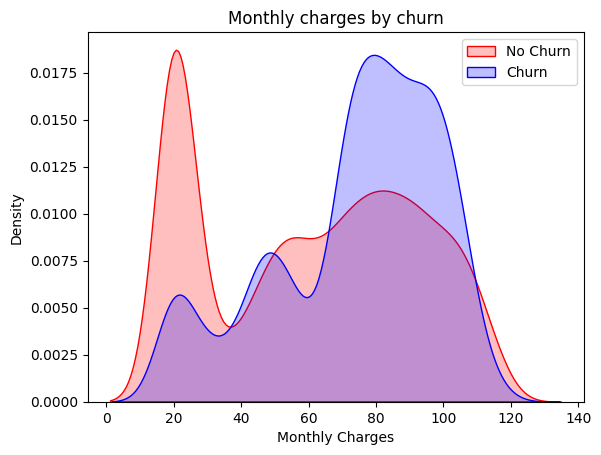

In [47]:
# distribution of monthly charges between customers who churned and those who did not churn.
Mth = sns.kdeplot(df_encoded.MonthlyCharges[(df_encoded["Churn"] == 0) ],
                color="Red", shade = True)
Mth = sns.kdeplot(df_encoded.MonthlyCharges[(df_encoded["Churn"] == 1) ],
                ax =Mth, color="Blue", shade= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')

Churn is high when Monthly Charges ar high

/tmp/ipykernel_27/2322755719.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(df_encoded.TotalCharges[(df_encoded["Churn"] == 0) ],
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_27/2322755719.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  Tot = sns.kdeplot(df_encoded.TotalCharges[(df_encoded["Churn"] == 1) ],
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

Text(0.5, 1.0, 'Total charges by churn')

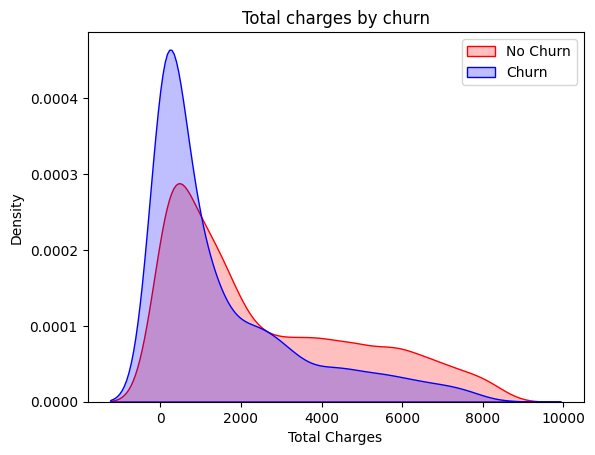

In [48]:
Tot = sns.kdeplot(df_encoded.TotalCharges[(df_encoded["Churn"] == 0) ],
                color="Red", shade = True)
Tot = sns.kdeplot(df_encoded.TotalCharges[(df_encoded["Churn"] == 1) ],
                ax =Tot, color="Blue", shade= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

higher Churn at lower Total Charges

<Axes: >

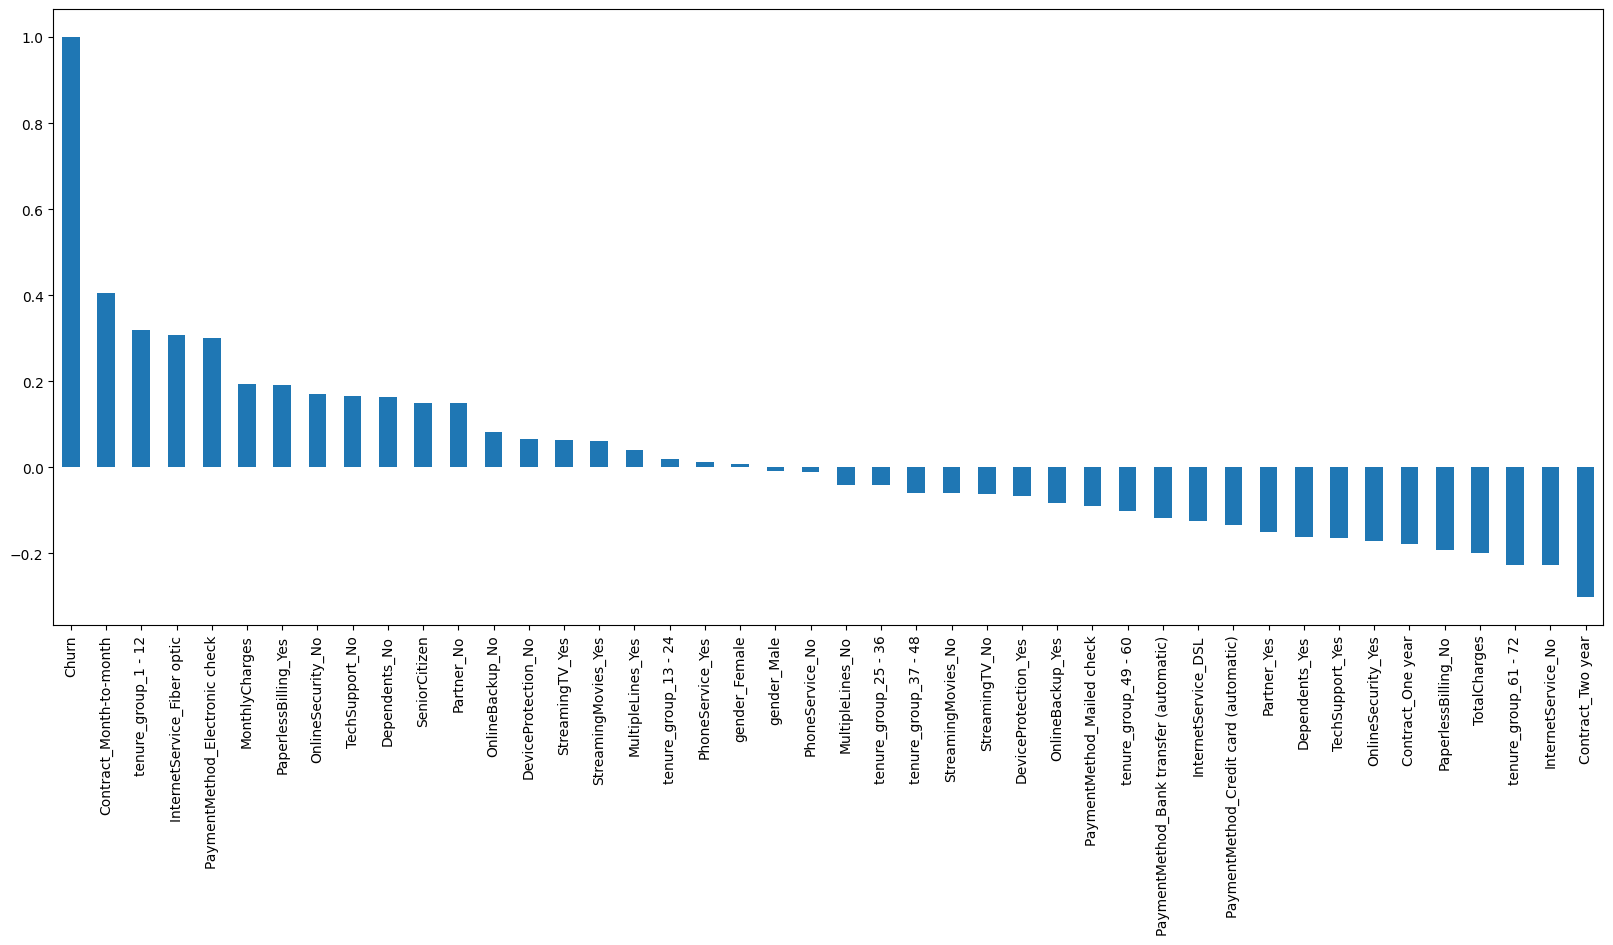

In [49]:
plt.figure(figsize=(20,8))
df_encoded.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

HIGH Churn seen in case of Month to month contracts, No online security, No Tech support, First year of subscription and Fibre Optics Internet

LOW Churn is seens in case of Long term contracts, Subscriptions without internet service and The customers engaged for 5+ years

Factors like Gender, Availability of PhoneService and # of multiple lines have alomost NO impact on Churn

* People leaving more when they have month-to-month contracts.
* If there's no online security or tech support, customers are more likely to leave.
* People tend to stay longer when they have long-term contracts.
* If the subscription doesn't include internet, there's less chance of people leaving.
* New subscribers in their first year tend to stop using the service.
* Customers with fiber optics internet are more likely to leave.

<Axes: >

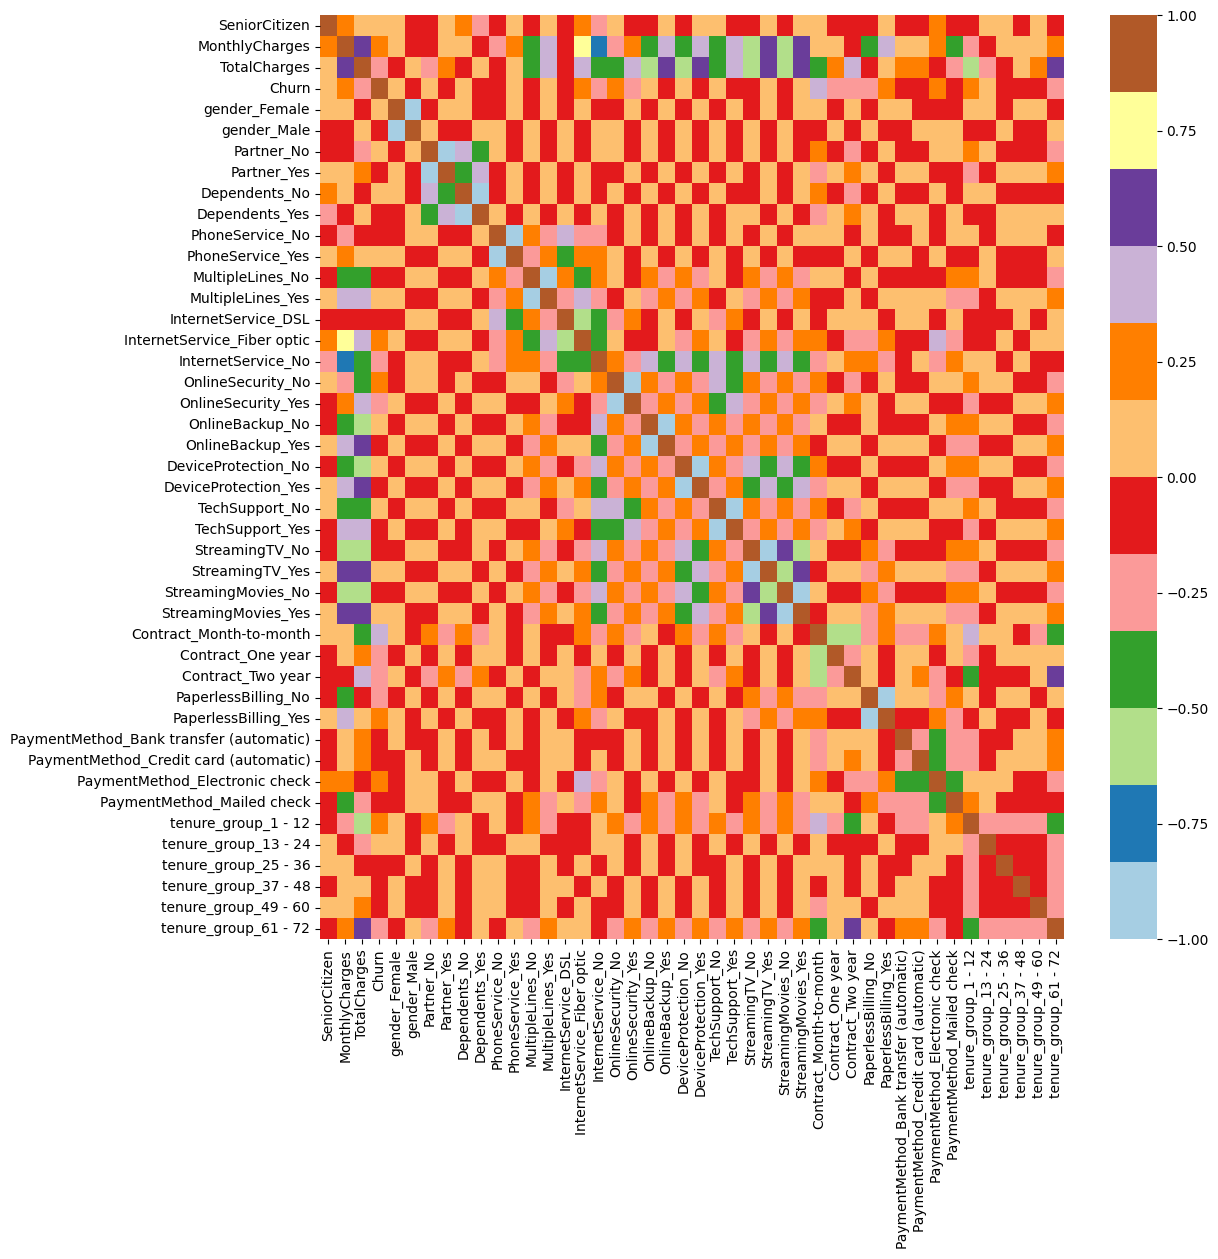

In [50]:
plt.figure(figsize=(12,12))
sns.heatmap(df_encoded.corr(), cmap="Paired")

In [51]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 44 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   SeniorCitizen                            7032 non-null   int64
 1   MonthlyCharges                           7032 non-null   int64
 2   TotalCharges                             7032 non-null   int64
 3   Churn                                    7032 non-null   int64
 4   gender_Female                            7032 non-null   int64
 5   gender_Male                              7032 non-null   int64
 6   Partner_No                               7032 non-null   int64
 7   Partner_Yes                              7032 non-null   int64
 8   Dependents_No                            7032 non-null   int64
 9   Dependents_Yes                           7032 non-null   int64
 10  PhoneService_No                          7032 non-null   int64
 11  PhoneServ

In [52]:
df_encoded.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


In [53]:
x = df_encoded.drop('Churn',axis=1)
x

,SeniorCitizen,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1 - 12,tenure_group_13 - 24,tenure_group_25 - 36,tenure_group_37 - 48,tenure_group_49 - 60,tenure_group_61 - 72
0,0,29,29,1,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,1,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53,108,0,1,1,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,84,1990,0,1,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
7039,0,103,7362,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,1
7040,0,29,346,1,0,0,1,0,1,1,...,0,0,1,0,1,0,0,0,0,0
7041,1,74,306,0,1,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0


In [54]:
y = df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7032, dtype: int64

In [55]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


# Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(random_state=42,max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [58]:
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.7832

Confusion Matrix:
[[909  95]
 [210 193]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1004
           1       0.67      0.48      0.56       403

    accuracy                           0.78      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.77      0.78      0.77      1407



Accuracy is cursed in imbalanced datasets.
SMOTEENN (UpSampling + ENN)

 # Using SMOTE to make the data balanced 

In [59]:
from imblearn.combine import SMOTEENN

sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x, y)

In [60]:
xr_train,xr_test,yr_train,yr_test=train_test_split(X_resampled, y_resampled,test_size=0.25)

In [61]:
model_sm = LogisticRegression(random_state=42,max_iter=1000)
model_sm.fit(xr_train, yr_train)
y_pred_sm = model_sm.predict(xr_test)

In [62]:
accuracy_lr = accuracy_score(yr_test, y_pred_sm)
conf_matrix_lr = confusion_matrix(yr_test, y_pred_sm)
classification_rep_lr = classification_report(yr_test, y_pred_sm)

In [63]:
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_lr)
print("\nClassification Report:")
print(classification_rep_lr)

Accuracy: 0.9474

Confusion Matrix:
[[613  33]
 [ 43 755]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       646
           1       0.96      0.95      0.95       798

    accuracy                           0.95      1444
   macro avg       0.95      0.95      0.95      1444
weighted avg       0.95      0.95      0.95      1444



Better accuracy with balanced data

# Trying with multiple models

In [64]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}

for model_name, model in models.items():
    model.fit(xr_train, yr_train)
    yr_pred = model.predict(xr_test)
    accuracy = accuracy_score(yr_test, yr_pred)
    classification_rep = classification_report(yr_test, yr_pred)
    conf_matrix = confusion_matrix(yr_test, yr_pred)
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_rep,
        'Confusion Matrix': conf_matrix
    }

In [65]:
results['Logistic Regression'] = {
    'Accuracy': accuracy_lr,
    'Classification Report': classification_rep_lr,
    'Confusion Matrix': conf_matrix_lr
}

In [66]:
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:")
    print(result['Classification Report'])
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])
    print("\n" + "="*50 + "\n")

Model: SVM
Accuracy: 0.7583
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       646
           1       0.82      0.72      0.77       798

    accuracy                           0.76      1444
   macro avg       0.76      0.76      0.76      1444
weighted avg       0.77      0.76      0.76      1444

Confusion Matrix:
[[518 128]
 [221 577]]


Model: Random Forest
Accuracy: 0.9536
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       646
           1       0.96      0.96      0.96       798

    accuracy                           0.95      1444
   macro avg       0.95      0.95      0.95      1444
weighted avg       0.95      0.95      0.95      1444

Confusion Matrix:
[[614  32]
 [ 35 763]]


Model: Gradient Boosting
Accuracy: 0.9584
Classification Report:
              precision    recall  f1-score   support

           0       0.95     

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


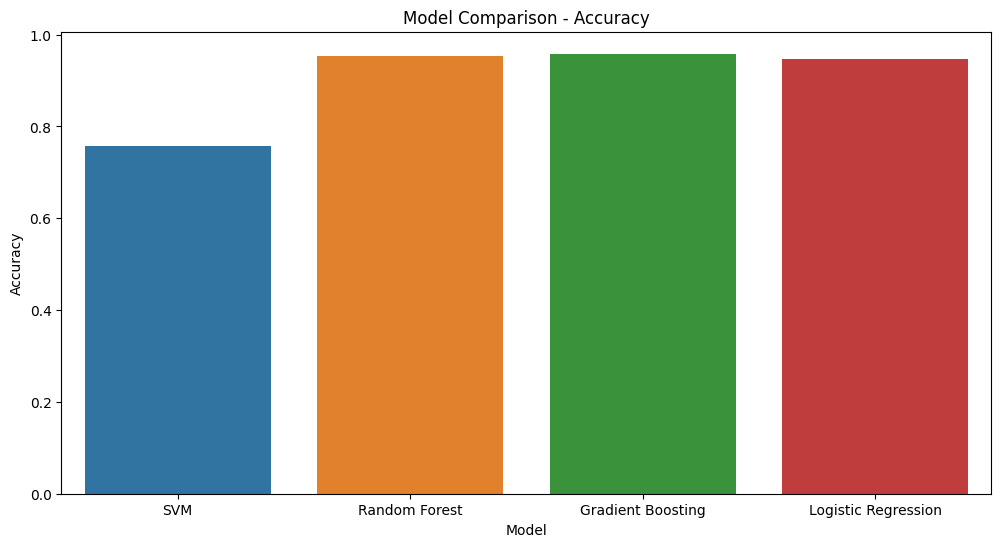

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(results.keys()), y=[result['Accuracy'] for result in results.values()])
plt.title('Model Comparison - Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


# Pickling the model

In [68]:
# import pickle
# from sklearn.svm import SVC
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# gb_model = GradientBoostingClassifier(random_state=42)
# gb_model.fit(xr_train, yr_train)

# with open('gradient_boosting_model.pkl', 'wb') as file:
#     pickle.dump(gb_model, file)



In [69]:
# with open('gradient_boosting_model.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)
    
# yr_pred_loaded = loaded_model.predict(xr_test)


# accuracy_loaded = accuracy_score(yr_test, yr_pred_loaded)
# classification_rep_loaded = classification_report(yr_test, yr_pred_loaded)
# conf_matrix_loaded = confusion_matrix(yr_test, yr_pred_loaded)


# print("Accuracy:", accuracy_loaded)
# print("Classification Report:")
# print(classification_rep_loaded)
# print("Confusion Matrix:")
# print(conf_matrix_loaded)